# Intervention


In [1]:
import torch, transformer_lens
from measureLM import visualizing, decoding, patching

In [2]:
model = transformer_lens.HookedTransformer.from_pretrained("gpt2-medium").to("mps")
model.cfg.spacing = "Ġ"
model.tokenizer.pad_token = model.tokenizer.eos_token

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-medium into HookedTransformer
Moving model to device:  mps


### 1) Get activations

/Users/niklasstoehr/Code/measureLM/measureLM/decoding.py:56: UserWarning: MPS: nonzero op is supported natively starting from macOS 13.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Indexing.mm:218.)
  batch_idx, seq_idx = (tokens == select_token_id).nonzero(as_tuple=True)
/Users/niklasstoehr/Code/measureLM/measureLM_venv/lib/python3.9/site-packages/torch/functional.py:864: UserWarning: MPS: unique_consecutive op is supported natively starting from macOS 13.0. Falling back on CPU. This may have performace implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Unique.mm:332.)
  output, inverse_indices, counts = _VF.unique_consecutive(  # type: ignore[attr-defined]
/Users/niklasstoehr/Code/measureLM/measureLM/decoding.py:61: UserWarning: torch.cumsum supported by MPS on MacOS 13+, please upgrade (Triggered 


prompt 0
layer 0: [(0.0002, 'France'), (0.0003, 'Paris'), (0.0005, 'Poland'), (0.0002, 'Warsaw')]
layer 1: [(0.0002, 'France'), (0.0004, 'Paris'), (0.0003, 'Poland'), (0.0003, 'Warsaw')]
layer 2: [(0.0002, 'France'), (0.0003, 'Paris'), (0.0003, 'Poland'), (0.0003, 'Warsaw')]
layer 3: [(0.0003, 'France'), (0.0006, 'Paris'), (0.0005, 'Poland'), (0.0005, 'Warsaw')]
layer 4: [(0.0006, 'France'), (0.0012, 'Paris'), (0.0004, 'Poland'), (0.0004, 'Warsaw')]
layer 5: [(0.0004, 'France'), (0.0009, 'Paris'), (0.0002, 'Poland'), (0.0003, 'Warsaw')]
layer 6: [(0.0003, 'France'), (0.0012, 'Paris'), (0.0003, 'Poland'), (0.0002, 'Warsaw')]
layer 7: [(0.0009, 'France'), (0.0016, 'Paris'), (0.001, 'Poland'), (0.0007, 'Warsaw')]
layer 8: [(0.0013, 'France'), (0.0012, 'Paris'), (0.0012, 'Poland'), (0.0009, 'Warsaw')]
layer 9: [(0.0025, 'France'), (0.007, 'Paris'), (0.0022, 'Poland'), (0.0008, 'Warsaw')]
layer 10: [(0.0029, 'France'), (0.0222, 'Paris'), (0.004, 'Poland'), (0.0024, 'Warsaw')]
layer 11: [(0

/Users/niklasstoehr/Code/measureLM/measureLM/visualizing.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


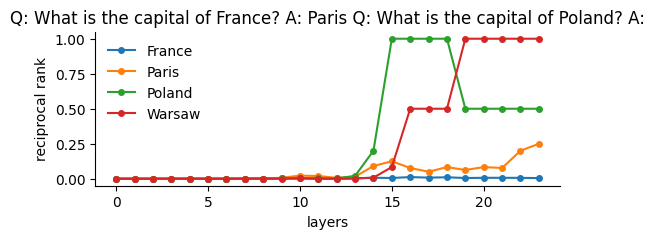

In [3]:
prompts = ['Q: What is the capital of France? A: Paris Q: What is the capital of Poland? A:']

logits, activs, tokens = decoding.encode(prompts, model)
layer_scores = decoding.early_decoding(activs, model)


token_candidates = ["France", "Paris", "Poland", "Warsaw"]

tok_idx = decoding.token_select(tokens, model)
scored_tokens = decoding.scores_to_tokens(layer_scores[tok_idx], model, mode=token_candidates)
visualizing.visualize_token_ranks(scored_tokens, token_candidates, prompts)

### (2) Use activations to intervene

['Ġexcellent', 'Ġgreat', 'Ġmug']
extracting blocks.0.hook_resid_post
extracting blocks.1.hook_resid_post
extracting blocks.2.hook_resid_post
extracting blocks.3.hook_resid_post
extracting blocks.4.hook_resid_post
extracting blocks.5.hook_resid_post
extracting blocks.6.hook_resid_post
extracting blocks.7.hook_resid_post
extracting blocks.8.hook_resid_post
extracting blocks.9.hook_resid_post
extracting blocks.10.hook_resid_post
extracting blocks.11.hook_resid_post
extracting blocks.12.hook_resid_post
extracting blocks.13.hook_resid_post
extracting blocks.14.hook_resid_post
patching blocks.15.hook_mlp_out
extracting blocks.15.hook_resid_post
patching blocks.16.hook_mlp_out
extracting blocks.16.hook_resid_post
patching blocks.17.hook_mlp_out
extracting blocks.17.hook_resid_post
patching blocks.18.hook_mlp_out
extracting blocks.18.hook_resid_post
patching blocks.19.hook_mlp_out
extracting blocks.19.hook_resid_post
patching blocks.20.hook_mlp_out
extracting blocks.20.hook_resid_post
patching

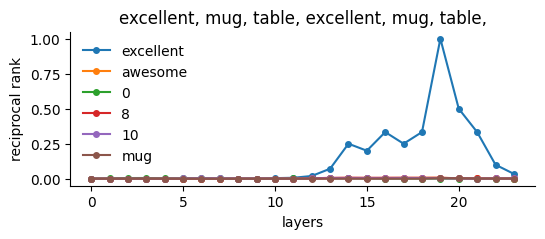

In [4]:
new_prompts = ["excellent, mug, table, excellent, mug, table,"]
new_logits, new_activs, new_tokens = decoding.encode(new_prompts, model)
pred = model.tokenizer.convert_ids_to_tokens(torch.topk(new_logits[:, -1, :], k=3).indices.tolist()[0])
print(pred)

patch_logits, resid_post = patching.intervene(new_tokens, activs, model, patch_tok_idx=-1, l_start_end=[15, 30])
resid_layer_scores = decoding.early_decoding(resid_post, model)

pred = model.tokenizer.convert_ids_to_tokens(torch.topk(patch_logits[:, -1, :], k=3).indices.tolist()[0])
print(pred)

new_token_candidates = ["excellent", "awesome", "0", "8", "10", "mug"]

## scoring
tok_idx = decoding.token_select(new_tokens, model)
scored_tokens = decoding.scores_to_tokens(resid_layer_scores[tok_idx], model, mode=new_token_candidates)
visualizing.visualize_token_ranks(scored_tokens, new_token_candidates, new_prompts)
